#### The paper being implemented is found here: https://arxiv.org/pdf/1508.06576.pdf

This implementation was carried out as a final project under Machine Learning @ Berkeley, as part of their intro ML course. While I wrote and modified much of what is here, credit is due to the ML@B staff and various other implementations online for creating the general structure of the project.

mLawrence

# Part 1: Build Model and Define Losses

#### First we want to initialize a VGG16 model we can use for style transfer.  

In [28]:
from keras.applications import vgg16
from keras.layers import Input, Concatenate
from keras.models import Model, Sequential
from keras import backend as K
import tensorflow as tf

In [29]:
K.clear_session()
content_input = Input(batch_shape=(1, 224, 224, 3))
style_input = Input(batch_shape=(1, 224, 224, 3))
output_tensor = tf.get_variable("output_tensor", [1, 224, 224, 3])
output_input = Input(tensor=output_tensor)

## TODO: use a concatenate layer to concatenate the three inputs on the first axis.
alltens = [content_input,style_input,output_input]

input_tensor = tf.concat(alltens,axis=0)
#input_tensor = Concatenate(axis=0)(alltens)
input_tensor

<tf.Tensor 'concat:0' shape=(3, 224, 224, 3) dtype=float32>

In [30]:
# We now create a pretrained VGG 16 model, which is really easy to do in Keras
# include_top=False ensures we don't use the fully connected layers.
vgg_model = vgg16.VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)
# We can now look at the structure of this model
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [31]:
print([layer.name for layer in vgg_model.layers])

['input_4', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool']


In [32]:
# now select one of the above listed layers to be the layer to use for content information
# and select some number of layers (maybe 2 or 3 layers) from the above layers to be the
# style information. If you choose layers closer to the input this will use 
# more simplistic features, and choosing layers closer to the end will use more complicated
# abstracted features.
content_layer = 'block4_conv2'

#‘conv11’, ‘conv21’, ‘conv31’, ‘conv41’ and ‘conv51’ 

style_layers = [

    'block1_conv1',
   'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1']
    
    

# you can also play with the_content and style loss weights if you want to. this will effect 
# how stylized vs similar to the content image the output will look.

#content_loss_weight = 1.5
#style_loss_weight = 10.0

content_loss_weight = .025
style_loss_weight = 5.0
    
style_layers, len(style_layers)

(['block1_conv1',
  'block2_conv1',
  'block3_conv1',
  'block4_conv1',
  'block5_conv1'],
 5)

In [33]:
layers_dict = dict([(layer.name, layer.output) for layer in vgg_model.layers])
layers_dict

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 224, 224, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 224, 224, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 112, 112, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 112, 112, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 112, 112, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 56, 56, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 56, 56, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 56, 56, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 56, 56, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 28, 28, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(3, 28, 28, 512) dtype=float32>,
 'block4_co

### Loss Functions
We want to define our style transfer losses now. First, we are going to define a feature reconstruction loss based on our content features and our output features. Using tensorflow functions implement the following loss function: $$\frac{1}{2} \sum_{i,j, k} (F_{ijk} - P_{ijk})^2$$ where $F$ is the 3D tensor of content features and $P$ is the 3D tensor of our output image features. 

In [34]:
def feature_reconstruction_loss(content_img_features, output_img_features):
    """Takes a tensor representing a layer of VGG features from the content image
    and a tensor representing a layer of VGG features from the current output image and returns a loss value.
    """
    return .5*tf.reduce_sum( 
                            tf.squared_difference(content_img_features,output_img_features)
                           )

Now we wish to define our style loss function. First, we have to take our features and represent them as a Gram Matrix, for more information on Gram Matrices and this loss function you can read the paper if you like. Then we wish to implement the loss function:
$$ \frac{1}{4H^2W^2C^2} \sum_{ij} (G_{ij} - A_{ij})^2 $$ where $G$ is the Gram matrix of the output image features and $A$ is the Gram Matrix of the style image features. 

In [35]:
def gram_matrix(x):
    # make channels first dimension
    x = tf.transpose(x, (2, 0, 1))
    # flatten everything but channels so x is now (C, H*W)
    x = tf.reshape(x, tf.stack([-1, tf.reduce_prod(tf.shape(x)[1:])]))
    return tf.matmul(x, tf.transpose(x))

In [36]:
def style_loss(style_img_features, output_img_features, img_shape):
    """Takes a tensor representing a layer of VGG features from the style image and a tensor
    representing a layer of VGG features from the current output image and returns 
    the style loss for these features.
    """
    
    constants = 4*(img_shape[0]*img_shape[1]*img_shape[2])**2
    
    gram_G = gram_matrix(output_img_features)
    gram_A = gram_matrix(style_img_features)
                         
    return tf.reduce_sum(tf.squared_difference(gram_G,gram_A))/constants

In [37]:
content_features = layers_dict[content_layer]

content_img_features = content_features[0, :, :, :] 
output_content_features = content_features[2, :, :, :]

content_loss = feature_reconstruction_loss(content_img_features, output_content_features)

In [38]:
total_style_loss = tf.zeros(1)
weight = 1.0 / len(style_layers)

for style_layer in style_layers:
    
    style_features = layers_dict[style_layer]
    style_img_features = style_features[1, :, :, :]
    output_img_features = style_features[2, :, :, :]
    
    
    total_style_loss += weight * style_loss(style_img_features, output_img_features, (224, 224, 3))
    
    
total_style_loss

<tf.Tensor 'add_4:0' shape=(1,) dtype=float32>

Now we need to combine our two loss functions using the weightings we defined earlier. 

In [39]:
total_loss = style_loss_weight*total_style_loss + content_loss_weight*content_loss 
total_loss

<tf.Tensor 'add_5:0' shape=(1,) dtype=float32>

In [40]:
optimize = tf.train.AdamOptimizer(learning_rate=10).minimize(total_loss, var_list=[output_tensor])
optimize

<tf.Operation 'Adam' type=NoOp>

# Part 2: Feeding in Images

We now want to load and preprocess our images. Keras provides a `load_img` function that conviently loads our image and then cuts it down to our target size. Keras also provides a `vgg16.preprocess_input` that preprocesses images to be in the format vgg16 expects. 

In [41]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

def load_image(img_path):
    img = load_img(img_path,target_size=(224,224,3))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg16.preprocess_input(img)
    return img

def deprocess_image(x):
    x = x.reshape((224, 224, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def darken_image(x):
    x = x.reshape((224, 224, 3))
    x[:, :, 0] -= 103.939
    x[:, :, 1] -= 116.779
    x[:, :, 2] -= 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [42]:
import os
os.listdir('images')

['starry.jpg',
 'segre.PNG',
 'scream.jpg',
 'ivan.jpg',
 'gradbest.jpg',
 'van_gogh.jpg',
 'resized_grad.jpg',
 'Oski.jpg',
 'monet_style.jpg',
 'gradbest_final.jpg',
 'kiyoko.jpeg',
 'output.png',
 'crab_nebula.jpg',
 'yas.jpg',
 'campanile.jpg',
 'scenery.jpg']

This part is messy from playing around. The last two lines are generally useful.

In [43]:
oski_img_path = 'images/Oski.jpg'
crab_img_path = 'images/crab_nebula.jpg'
vg_img_path = 'images/van_gogh.jpg'

ivan_img_path = 'images/ivan.jpg'
scenery_img_path = 'images/scenery.jpg'

scream_img_path = 'images/scream.jpg'
starry_img_path = 'images/starry.jpg'

yas_img_path = 'images/yas.jpg'
campanile = 'images/campanile.jpg'

monet_style = 'images/monet_style.jpg'

grad = 'images/gradbest_final.jpg'
other_grad = 'images/resized_grad.jpg'
segre = 'images/segre.PNG'

content_img_path = oski_img_path
style_img_path = vg_img_path

In [44]:
content_img = load_image(content_img_path)
style_img = load_image(style_img_path)

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

In [46]:
#plt.imshow(content_img)

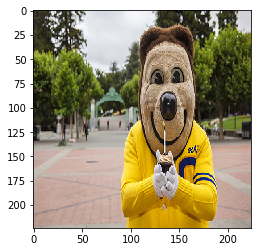

In [47]:
plt.imshow(deprocess_image(content_img))

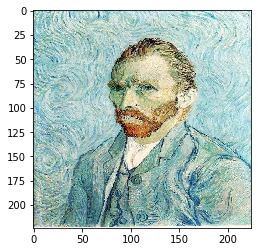

In [48]:
plt.imshow(deprocess_image(style_img))

In [49]:
assign_var = tf.assign(output_tensor, content_img)
sess = K.get_session()
var = sess.run(assign_var)

In [50]:
import time

Running iteration: 0
6.48562479019165
[8.395347e+09]
Running iteration: 1
6.377702951431274
[7.8110193e+09]
Running iteration: 2
6.314954042434692
[7.406026e+09]
Running iteration: 3
6.273591041564941
[7.0754017e+09]
Running iteration: 4
6.478470802307129
[6.615823e+09]
Running iteration: 5
6.444658994674683
[6.156406e+09]
Running iteration: 6
6.278012990951538
[5.807391e+09]
Running iteration: 7
6.276642799377441
[5.5381294e+09]
Running iteration: 8
6.2666051387786865
[5.29754e+09]
Running iteration: 9
7.015311241149902
[5.014323e+09]
Running iteration: 10
6.338975667953491
[4.7307213e+09]
Running iteration: 11
6.260739803314209
[4.502347e+09]
Running iteration: 12
6.398267984390259
[4.2704878e+09]
Running iteration: 13
6.253230810165405
[4.0261468e+09]
Running iteration: 14
6.2667460441589355
[3.8211103e+09]
Running iteration: 15
6.31829833984375
[3.6501673e+09]
Running iteration: 16
7.050322771072388
[3.4788308e+09]
Running iteration: 17
7.46391487121582
[3.3071788e+09]
Running iter

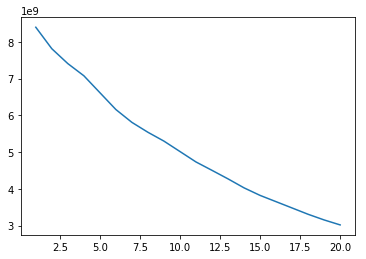

In [55]:
n_iterations = 20

iteration = np.arange(1,n_iterations+1)
loss_vals = []

for i in range(n_iterations):
    
    
    print("Running iteration: {}".format(i))
    time1 = time.time()
    _, output_val, loss = sess.run([optimize, output_tensor, total_loss], feed_dict={content_input: content_img, style_input: style_img})
    time2 = time.time()
    print(time2-time1)
    print(loss)
    loss_vals += [loss]
    
print('Done')
loss_vals = np.array(loss_vals)
plt.plot(iteration,loss_vals)

In [56]:
output_img = deprocess_image(output_val) 

In [58]:
output_img = darken_image(output_val)

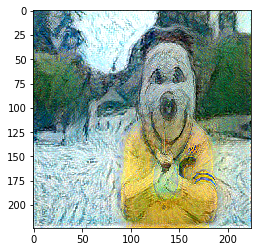

In [59]:
plt.imshow(output_img)

# Writeup

Style transfer is an extension of a vast CNN, VGG16, which is used for image classification. It works by taking an input photo for both content and style, running them each through the CNN, then comparing their outputs at various layers. The outputs from these layers can be thought of as filtered versions of the input photo, which are powerful because they pick out main distinguishing features of the photo. By using these filters to extract some concept of a style, then filtering for the main content of another given photo, a loss can be constructed using weights of one's choosing to turn creating a new piece of art into an optimization problem. The solution to this optimization problem is a photo that fits the right amount of style and content based upon the given weights. We iteratively alter a photo using gradient descent to numerically minimize the loss function, and thus produce a better photo with each loop.

# Default Settings

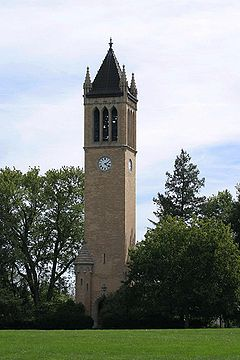
Content Image

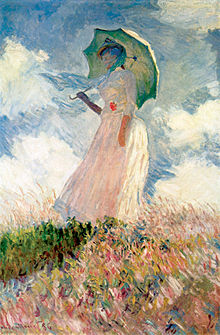
Style Image

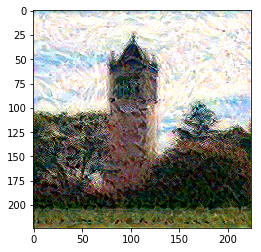
Output Image

Settings:

Content layer: Block 4, Conv 2

Style layers: Block 3, Conv 1
              Block 5, Conv 1

Weights: Content = 5, Style = 500

Additional: Darkened

# Default Pictures, New Parameters

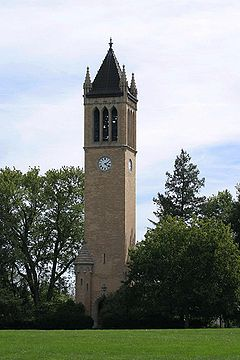
Content Image

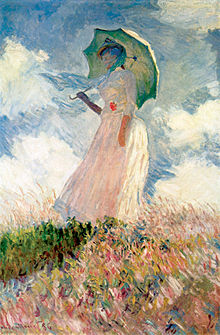
Style Image

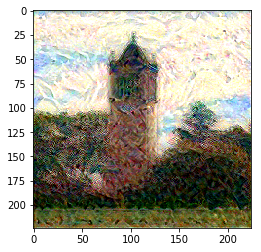
Output Image

Settings:

Content layer: Block 4, Conv 2

Style layers: Block 1, Conv 1
              Block 2, Conv 1
              Block 3, Conv 1
              Block 4, Conv 1
              Block 5, Conv 1

Weights: Content = 0.0005, Style = 5.0

# New Pictures, New Parameters

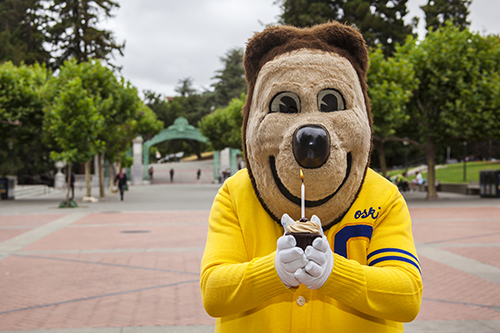
Content

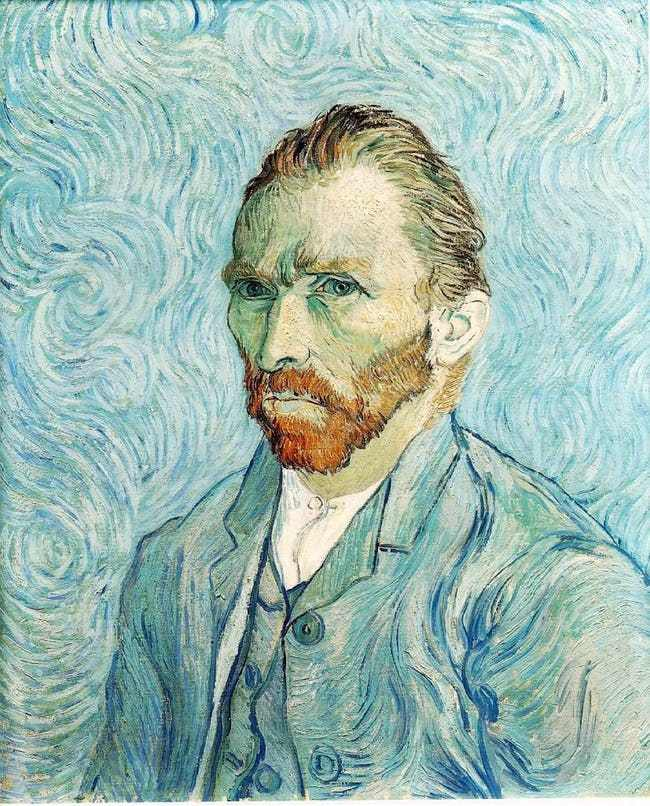
Style

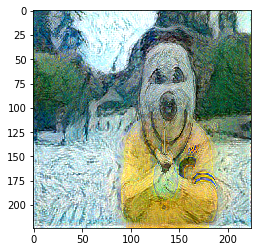
Output

Settings:

Content layer: Block 4, Conv 2

Style layers: Block 1, Conv 1
              Block 2, Conv 1
              Block 3, Conv 1
              Block 4, Conv 1
              Block 5, Conv 1

Weights: Content = 0.025, Style = 5.0

Additional: Lightened